In [3]:
#setup
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

path = "Spotify_Extended_Streaming_History/"
dirs = os.listdir(path)

files=[]
for file in dirs:
    if file.endswith(".json"):
        files.append(path+file)
files.pop()

df = pd.concat(map(pd.read_json, files), ignore_index=True)

MONTHS = [0, "January","February","March","April","May","June","July","August","September","October","November","December"]

In [4]:
#cleaning/column adding
month = []
year = []
day = []
hour = []
for i in np.arange(0, len(df["ts"])):
    date = df["ts"][i].split("-")
    year.append(int(date[0]))
    month.append(MONTHS[int(date[1])])
    day.append(int(date[2][0:2]))
    hour.append(int(date[2][3:5]))
df.insert(0, "year", year)
df.insert(0, "month", month)
df.insert(0, "day", day)
df.insert(0, "hour", hour)
seconds_played = df["ms_played"]/1000
df.insert(0, "seconds_played",seconds_played)
df = df.fillna(value='None')
df = df.drop(df[df["episode_name"] != 'None'].index)
cleaned_df = df.drop(columns=["username", "ip_addr_decrypted",  "spotify_track_uri", "episode_name", "episode_show_name", "spotify_episode_uri", "user_agent_decrypted"])
cleaned_df = cleaned_df.rename(columns={"master_metadata_track_name": "song_name", 
                                        "master_metadata_album_artist_name": "artist_name", 
                                        "master_metadata_album_album_name": "album_name"})
cleaned_df.index = pd.RangeIndex(len(df.index))

In [5]:
def total_time(df):
    total = int(np.round(np.sum(df["seconds_played"])))
    start_date = f"{df.month[0]} {df.day[0]}, {df.year[0]}"
    end_date = f"{df.month[len(df)-1]} {str(df.day[len(df)-1])}, {df.year[len(df)-1]}"
    print(f"From {start_date} to {end_date} you have listened a total of")
    print(total, "seconds")
    #ew
    seconds = total%60
    minutes = total//60
    hours = minutes//60
    minutes = minutes%60
    days = hours//24
    hours = hours%24

    print(f"{days} days, {hours} hours, {minutes} minutes, {seconds} seconds")

def country(df):
    ax = cleaned_df['conn_country'].value_counts().plot(kind='bar')
    ax.set_yscale('log')
    plt.xticks(rotation=0)
    plt.xlabel('countries')
    plt.ylabel('count')
    plt.title('Connected Countries')
    display(pd.DataFrame(cleaned_df['conn_country'].value_counts()))

def most_listened(df, column):
    new_df = df[[column, 'seconds_played']].groupby(column).sum().sort_values(by=['seconds_played'], ascending=False)
    new_df.drop(index='None', inplace=True)
    top10 = new_df.head(10)
    minutes_played = np.round(top10['seconds_played']/60)
    minutes_played = [int(x) for x in minutes_played]
    top10.insert(1, 'minutes_played', minutes_played)
    top10 = top10.drop(columns='seconds_played')
    display(top10)
    new_df.head(10)

def most_listened_by(df, column1, column2, param):
    df = df[df[column2] == param]
    new_df = df[[column1, 'seconds_played']].groupby(column1).sum().sort_values(by=['seconds_played'], ascending=False)
    if 'None' in new_df.index:
        new_df.drop(index='None', inplace=True)
    top10 = new_df.head(10)
    minutes_played = np.round(top10['seconds_played']/60)
    minutes_played = [int(x) for x in minutes_played]
    top10.insert(1, 'minutes_played', minutes_played)
    top10 = top10.drop(columns='seconds_played')
    display(top10)
    new_df.head(10)

In [11]:

most_listened(cleaned_df, 'song_name')
most_listened(cleaned_df, 'artist_name')
most_listened_by(cleaned_df, 'song_name', 'year', 2023)


,minutes_played
song_name,
Boy With Luv (feat. Halsey),19061
Spring Day,4027
ON,3848
Into the I-LAND,3581
eight(Prod.&Feat. SUGA of BTS),3285
Celebrity,3280
Save Me,3248
群青,3149
MIC Drop (Steve Aoki Remix) (Full Length Edition),3006


,minutes_played
artist_name,
BTS,58223
IU,18712
YOASOBI,15980
TWICE,14691
SEVENTEEN,7725
LE SSERAFIM,6499
NMIXX,5636
PENTAGON,4587
Imagine Dragons,3420


,minutes_played
song_name,
Boy With Luv (feat. Halsey),12937
ON,2678
Spring Day,2645
Into the I-LAND,2564
MIC Drop (Steve Aoki Remix) (Full Length Edition),2523
eight(Prod.&Feat. SUGA of BTS),2169
Celebrity,2154
Life Goes On,2037
DNA,1984


In [7]:
total_time(cleaned_df)

From February 8, 2016 to August 26, 2023 you have listened a total of
14930374 seconds
172 days, 19 hours, 19 minutes, 34 seconds


,count
conn_country,
US,100979
IS,109
FR,67
ES,52
HK,42
AE,40
ZZ,31
TW,29
DE,27


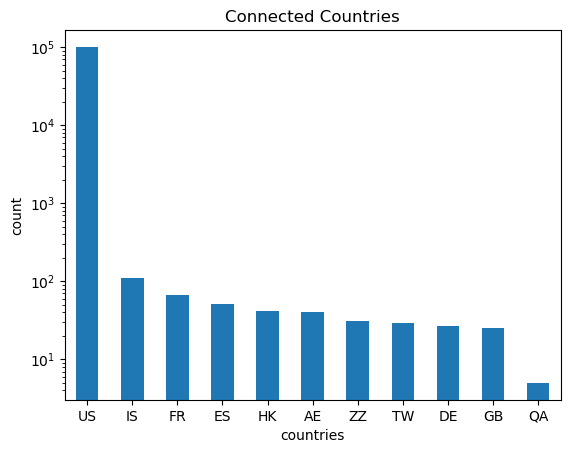

In [8]:
country(cleaned_df)

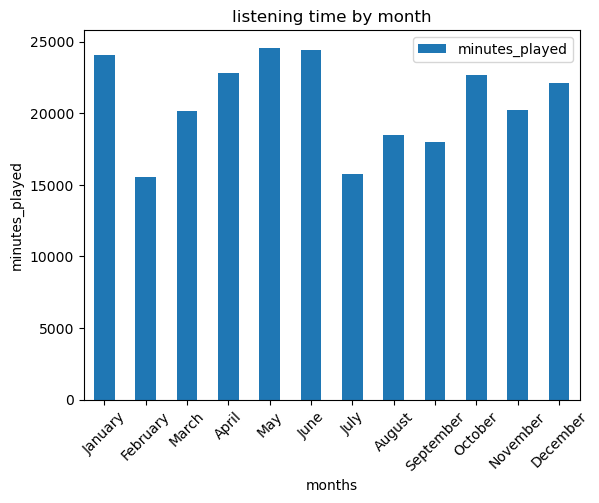

In [9]:
def listen_time_by_month(df):
    new_df = df[['month', 'seconds_played']]
    new_col = []
    for i in np.arange(new_df.shape[0]):
        new_col.append(MONTHS.index(new_df['month'][i]))
    new_df.insert(0, 'month_num', new_col)
    new_df = new_df.drop(columns='month')
    new_df = new_df.groupby('month_num').sum().sort_values(by=['month_num'], ascending=True)
    new_col = []
    for i in new_df.index:
        new_col.append(MONTHS[i])
    new_df.insert(0, 'month', new_col)
    #display(new_df)
    new_df.insert(2, 'minutes_played', np.round(new_df['seconds_played']/60))
    ax = new_df.plot(kind='bar', x='month', y='minutes_played')
    plt.xticks(rotation=45)
    plt.xlabel('months')
    plt.ylabel('minutes_played')
    plt.title('listening time by month')
listen_time_by_month(cleaned_df)

In [10]:
cleaned_df.tail(5)


,seconds_played,hour,day,month,year,ts,platform,ms_played,conn_country,song_name,artist_name,album_name,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode
101401,1.602,2,26,August,2023,2023-08-26T02:30:08Z,ios,1602,US,How You Like That,BLACKPINK,THE ALBUM,fwdbtn,fwdbtn,False,True,0.0,1693017006.0,False
101402,1.880,2,26,August,2023,2023-08-26T02:30:09Z,ios,1880,US,WANNABE,ITZY,IT'z ME,fwdbtn,fwdbtn,False,True,0.0,1693017008.0,False
101403,0.859,2,26,August,2023,2023-08-26T02:30:10Z,ios,859,US,Haegeum,Agust D,D-DAY,fwdbtn,fwdbtn,False,True,0.0,1693017010.0,False
101404,0.626,2,26,August,2023,2023-08-26T02:30:11Z,ios,626,US,MIROH,Stray Kids,Clé 1 : MIROH,fwdbtn,fwdbtn,False,True,0.0,1693017011.0,False
101405,1.648,2,26,August,2023,2023-08-26T02:30:13Z,ios,1648,US,Palette (feat. G-DRAGON),IU,Palette,fwdbtn,fwdbtn,False,True,0.0,1693017012.0,False
